# A Markovian model of evolving world IO network
https://sevamoo.github.io/Markovian_IO_SI_PLOSONE/

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
#import sompy as SOM
from pylab import matshow, savefig
from scipy.linalg import norm
import time

## Supporting Functions

In [2]:
def update_by_momentum(series, span, pred_period):
    result = []  # first value is same as series
    vals = series[-span - 1:]
    for n in range(pred_period):
        momentum_avg = np.mean(np.diff(vals))
        result.append(vals[-1] + momentum_avg)
        vals[-1] = result[-1]

    return result

In [3]:
def aggregate_economy_int_consumptions(WIOT):
    economy_n = 41
    industry_n = 35
    economy_int_consumptions_n = 1
    economy_produsction_costs_n = 1
    states_n = economy_n * industry_n + economy_n * 1 + industry_n * 1

    economy_income = np.zeros((economy_n * industry_n, economy_n))
    economy_int_consumptions = np.zeros((economy_n * industry_n, economy_n))
    ind = economy_n * industry_n
    for i in range(economy_n):
        # This data are stored in the last columns on the right side of WIOD.
        # They are in five subcategory that here we just sum them as the final consumption of the government (inc. households)
        col = i * 5 + ind
        economy_int_consumptions[:, i] = WIOT[:, col:col + 5].sum(axis=1)

    # I don't know why but sometimes it gets a bit negative?!!! due to change in inventory (5th column of economy consum)
    economy_int_consumptions[economy_int_consumptions < 0] = 0

    # This is Tax, Payments, ...
    industry_production_costs = np.around(
        WIOT[:].sum(axis=1) - WIOT[:, :economy_n * industry_n].sum(axis=0), decimals=5)

    return (economy_int_consumptions, industry_production_costs)

In [4]:
def build_markov_chain_Dense(
        Q,
        WIOT,
        economy_n,
        industry_n,
        economy_int_consumptions,
        industry_production_costs,
):
    e0 = time.time()
    eps = .001

    for i in range(0, economy_n * industry_n):

        # For industry interactions
        for j in range(0, economy_n * industry_n):
            Q[i, j] = WIOT[j, i]

        # For payments of industry to its economy: This is the source of income for the economy
        economy_ind_industry = i // industry_n
        Q[i, economy_n * industry_n + economy_ind_industry] = industry_production_costs[i]

        # For economy's costs (i.e. consumptions)
        ind_economy_inTM = economy_n * industry_n

        for j in range(economy_n):
            Q[j + ind_economy_inTM, i] = economy_int_consumptions[i, j]

    # We have row stochastic matrix! In the paper we have column stochastic!
    singular_industries = []
    for i in range(Q.shape[0]):
        s = sum(Q[i])

        if np.sum(Q[i] > 0) == 1:
            if np.where(Q[i] > 0) == i:

                # means absorbing state
                Q[i] = eps
                Q[i, i] = 1.
                s = sum(Q[i])
                Q[i] = np.divide(Q[i], s)
            else:
                pass
            # print(np.where(Q[i] > 0), i, np.sum(Q[:, i] > 0))

        if s == 0:
            singular_industries.append(i % economy_n)
            Q[i] = eps
            Q[i, i] = 1.
            s = sum(Q[i])
            Q[i] = np.divide(Q[i], s)
        else:
            Q[i] = np.divide(Q[i], s)
    print('Making the TM in {} second'.format(time.time() - e0))

    return (np.around(Q, decimals=10), list(np.unique(singular_industries)))

In [5]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

In [6]:
def Kemeny_constant(MC):
    from scipy.linalg import eig
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [7]:
# Sensitivity analysis on a single node
def change_node(M,
                economy_to_perturb=None,
                industry_to_perturb=None,
                percent=10):
    MC = M.copy()
    
    ind_indusrty_to_perturb_from_their_economy = []
    ind_indusrty_to_perturb_from_specific_industry = []

    if industry_to_perturb == industry_n:
        i = industry_n * economy_n + economy_to_perturb
    else:
        i = industry_to_perturb + (economy_to_perturb) * industry_n
        
    MC[i, :] = MC[i, :] * (1 + percent * .01)
    MC[:, i] = MC[:, i] * (1 + percent * .01)
    MC[i, i] = MC[i, i] / (1 + percent * .01)

    for i in range(MC.shape[0]):
        s = sum(MC[i])
        
        if s == 0:
            MC[i] = eps
            MC[i, i] = 1.
            s = sum(MC[i])
            MC[i] = np.divide(MC[i], s)

        else:
            MC[i] = np.divide(MC[i], s)

    return MC

## Load Dataset

In [8]:
economy_n = 41
industry_n = 35
header = pd.read_csv('./markov/Data/WIOD/header.csv', header=None)
economy_names = header.values[1, range(0, 1435, 35)]
industry_names = header.values[0, range(0, 35)]

In [9]:
Countries = pd.read_csv("./markov/Data/WIOD/Economies_Names.csv")

In [10]:
# We calculated this before from the WIOD, for GDP calculations
VA = pd.read_csv('./markov/Data/WIOD/VAs.csv', index_col=[0])

In [11]:
WIO = list()
for i in range(1995, 2012):
    d = pd.read_csv(
        './markov/Data/WIOD/wiot' + str(i) + '_row_apr12.csv', header=[0, 1, 2])
    WIO.append(d.values[:])
    print(i, d.shape)

1995 (1435, 1640)
1996 (1435, 1640)
1997 (1435, 1640)
1998 (1435, 1640)
1999 (1435, 1640)
2000 (1435, 1640)
2001 (1435, 1640)
2002 (1435, 1640)
2003 (1435, 1640)
2004 (1435, 1640)
2005 (1435, 1640)
2006 (1435, 1640)
2007 (1435, 1640)
2008 (1435, 1640)
2009 (1435, 1640)
2010 (1435, 1640)
2011 (1435, 1640)


## Using Power Iteration to calculate the steady state probabilities, Pi

In [12]:
Pi = []
TMs = []
Mixing_times = []
singular_ids = []

for i, WIOT in enumerate(WIO):
    economy_int_consumptions, industry_production_costs = aggregate_economy_int_consumptions(WIOT)
    economy_n = 41
    industry_n = 35
    states_n = economy_n * industry_n + economy_n
    TM = np.zeros((states_n, states_n))
    TM, singular_id = build_markov_chain_Dense(TM, WIOT, economy_n, industry_n,
                                               economy_int_consumptions,
                                               industry_production_costs)
    TMs.append(TM)
    singular_ids.extend(singular_id)
    t, mixing_ = simulate_markov(TM)
    Pi.append(t)
    Mixing_times.append(mixing_)

singular_ids = np.unique(singular_ids)

Making the TM in 1.8146002292633057 second
Iterating 290 times in 0.21093249320983887
Making the TM in 1.5485169887542725 second
Iterating 257 times in 0.21618103981018066
Making the TM in 1.5540997982025146 second
Iterating 251 times in 0.17022919654846191
Making the TM in 1.5319812297821045 second
Iterating 259 times in 0.1676807403564453
Making the TM in 1.587907075881958 second
Iterating 262 times in 0.17934536933898926
Making the TM in 1.6614978313446045 second
Iterating 240 times in 0.18500590324401855
Making the TM in 1.6484100818634033 second
Iterating 228 times in 0.1540238857269287
Making the TM in 1.5810279846191406 second
Iterating 229 times in 0.15870189666748047
Making the TM in 1.5824005603790283 second
Iterating 221 times in 0.15224838256835938
Making the TM in 1.5494496822357178 second
Iterating 208 times in 0.1509253978729248
Making the TM in 1.750147819519043 second
Iterating 190 times in 0.14004850387573242
Making the TM in 1.6624658107757568 second
Iterating 171 ti

## Average mixing time of Markov chains as an aggregate index of globalization

In [13]:
# We run the power iteration for several times to see if there are some variations in the mixing time
n = 100
Mixing_times_n_times = np.zeros((n, len(TMs)))
for i in range(n):
    for j in range(len(TMs)):
        t, mixing_ = simulate_markov(TMs[j], verbose='off')
        Mixing_times_n_times[i, j] = mixing_

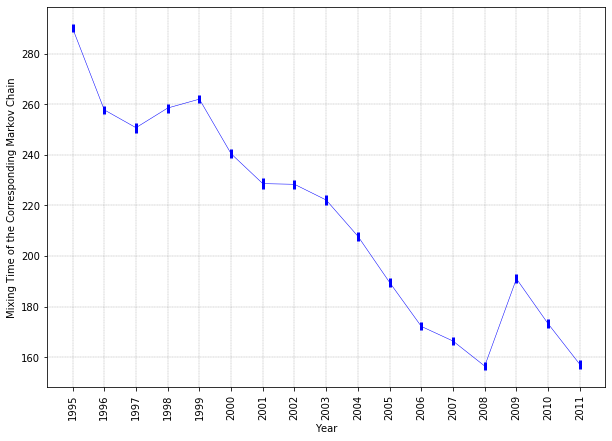

In [14]:
fig = plt.figure(figsize=(10, 7));
yerr = 3 * Mixing_times_n_times.std(axis=0)
plt.errorbar(
    range(1, 18),
    Mixing_times_n_times.mean(axis=0),
    yerr=yerr,
    fmt='-',
    color='b',
    ecolor='b',
    linewidth=.51,
    elinewidth=3)
plt.xticks(range(1, 18), range(1995, 2012))
label = range(1995, 2012)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
plt.xlabel('Year')
plt.xticks(range(1, 18), label, rotation=90)

plt.grid(linewidth=.31, color='gray', linestyle='--')
path = './markov/Images/Mixing_Time.tiff'
# fig.savefig(path,dpi=300)
plt.show();
plt.close();

## Kemeny constants of Markov chains as an aggregate index of globalization

In [15]:
Kemenys = []
for TM in TMs:
    K, pi = Kemeny_constant(TM)
    Kemenys.append(K)

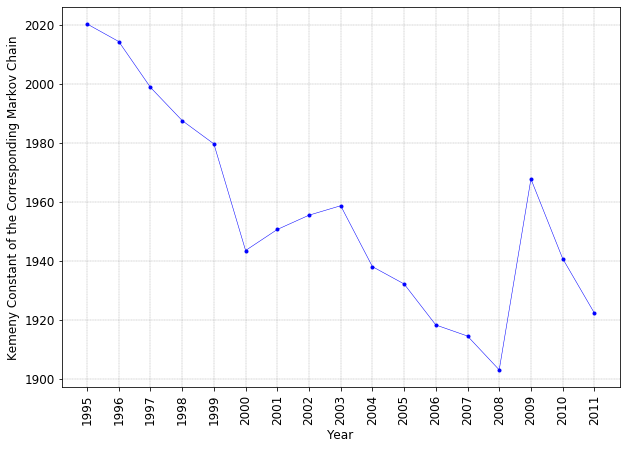

In [16]:
fig = plt.figure(figsize=(10, 7));
plt.plot(Kemenys, '.-b', linewidth=.51)
label = range(1995, 2012)
plt.xticks(range(17), label, rotation=90)
plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Kemeny Constant of the Corresponding Markov Chain')
font = {'size': 12}
plt.rc('font', **font)
path = './markov/Images/Kemeny.tiff'
# fig.savefig(path,dpi=300)
plt.show();
plt.close();

## GDP share of economies (red) compared to aggregated structural power (blue) over time

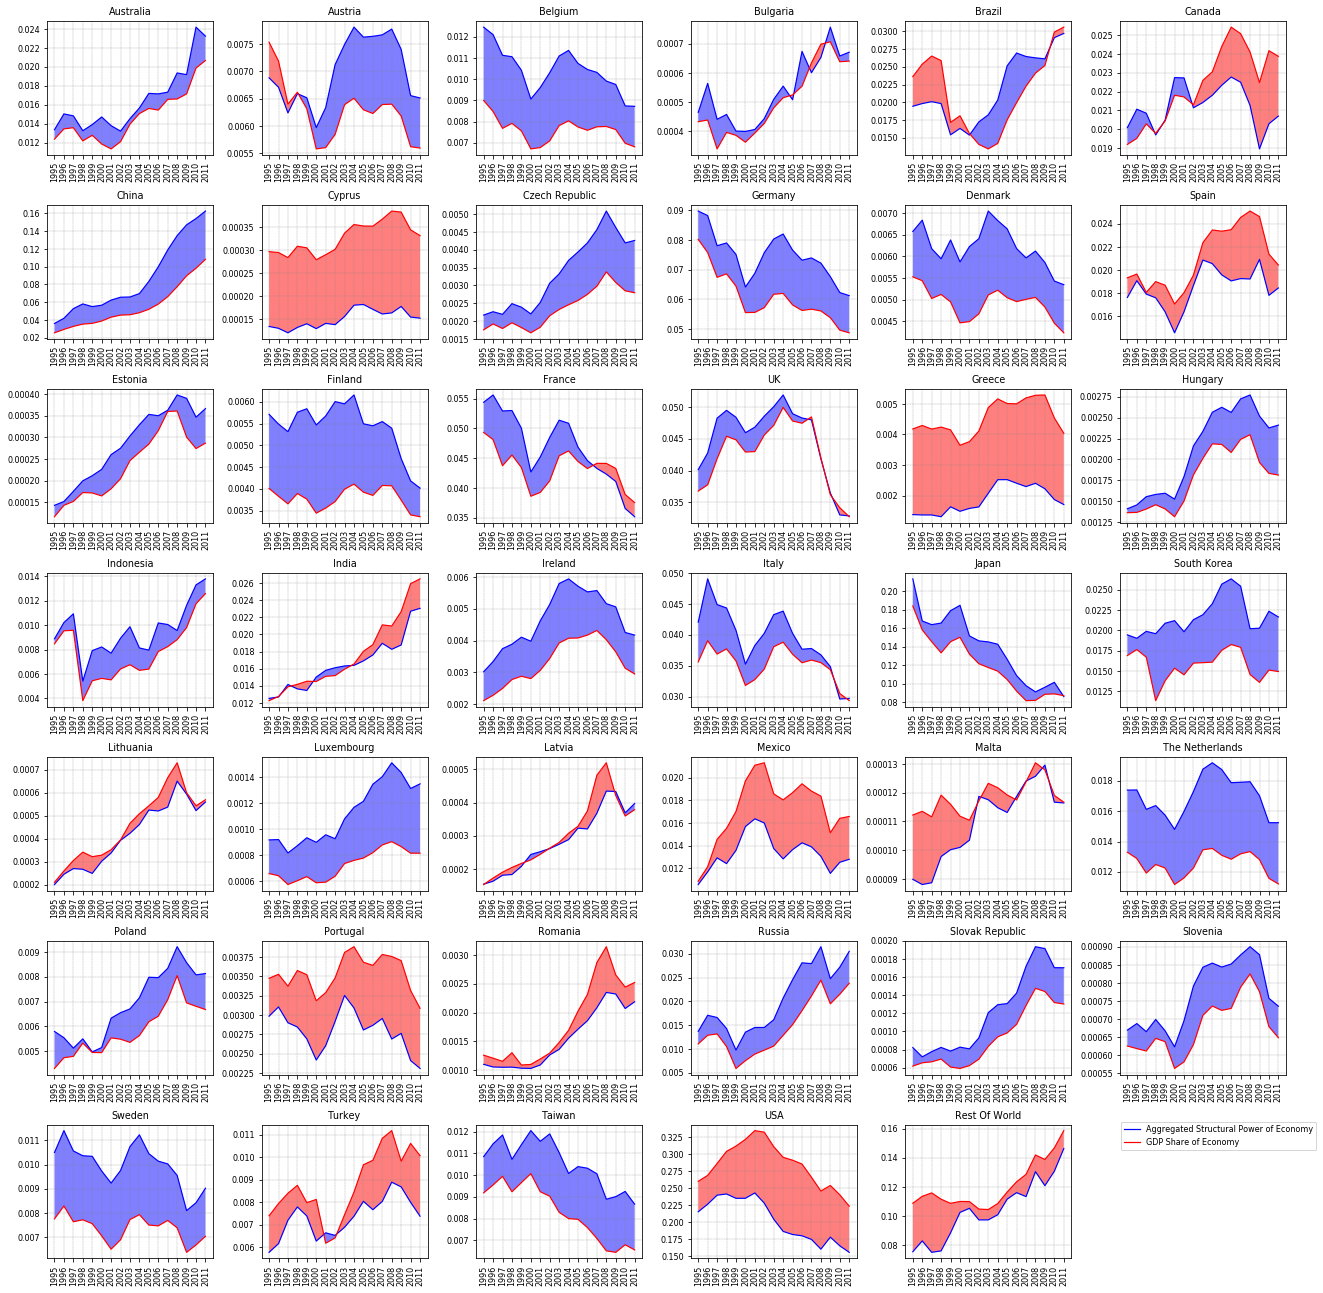

In [17]:
Data_all = np.asarray(Pi).T

fig = plt.figure(figsize=(18, 18))
font = {'size': 8}
plt.rc('font', **font)
GDP_shares = np.zeros((economy_n, 17))
Economies_shares = np.zeros((economy_n, 17))
for i in range(economy_n):
    ind_indusrty = range(i * industry_n, (i + 1) * industry_n)
    GDP_shares[i] = VA.values[:, ind_indusrty].sum(axis=1) / VA.values[:].sum(
        axis=1)

    plt.subplot(7, 6, i + 1)
    plt.title(Countries.Country[i])
    ind_indusrty = list(range(i * industry_n,
                         (i + 1) * industry_n)) + [industry_n * economy_n + i]
    Economies_shares[i] = Data_all[ind_indusrty].T.sum(axis=1)

    plt.plot(
        range(17),
        Economies_shares[i],
        '-b',
        linewidth=1.2,
        label='Aggregated Structural Power of Economy');
    plt.plot(
        range(17),
        GDP_shares[i],
        '-r',
        linewidth=1.2,
        label='GDP Share of Economy');
    y1 = Economies_shares[i]
    y2 = GDP_shares[i]
    x = range(17)

    plt.fill_between(
        x, y1, y2, where=y2 >= y1, facecolor='red', alpha=.5, interpolate=True)
    plt.fill_between(
        x, y1, y2, where=y2 <= y1, facecolor='blue', alpha=.5, interpolate=True)
    path = './markov/Images/GDP_Share_Pi.tiff'
    label = range(1995, 2012)
    plt.xticks(range(17), label, rotation=90)

    plt.tight_layout()

    plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.legend(bbox_to_anchor=(2.5, 1.05))
# fig.savefig(path,dpi=300)
plt.show();
plt.close();

## The effect of 99% slowdown of electrical and optical equipment industry of China

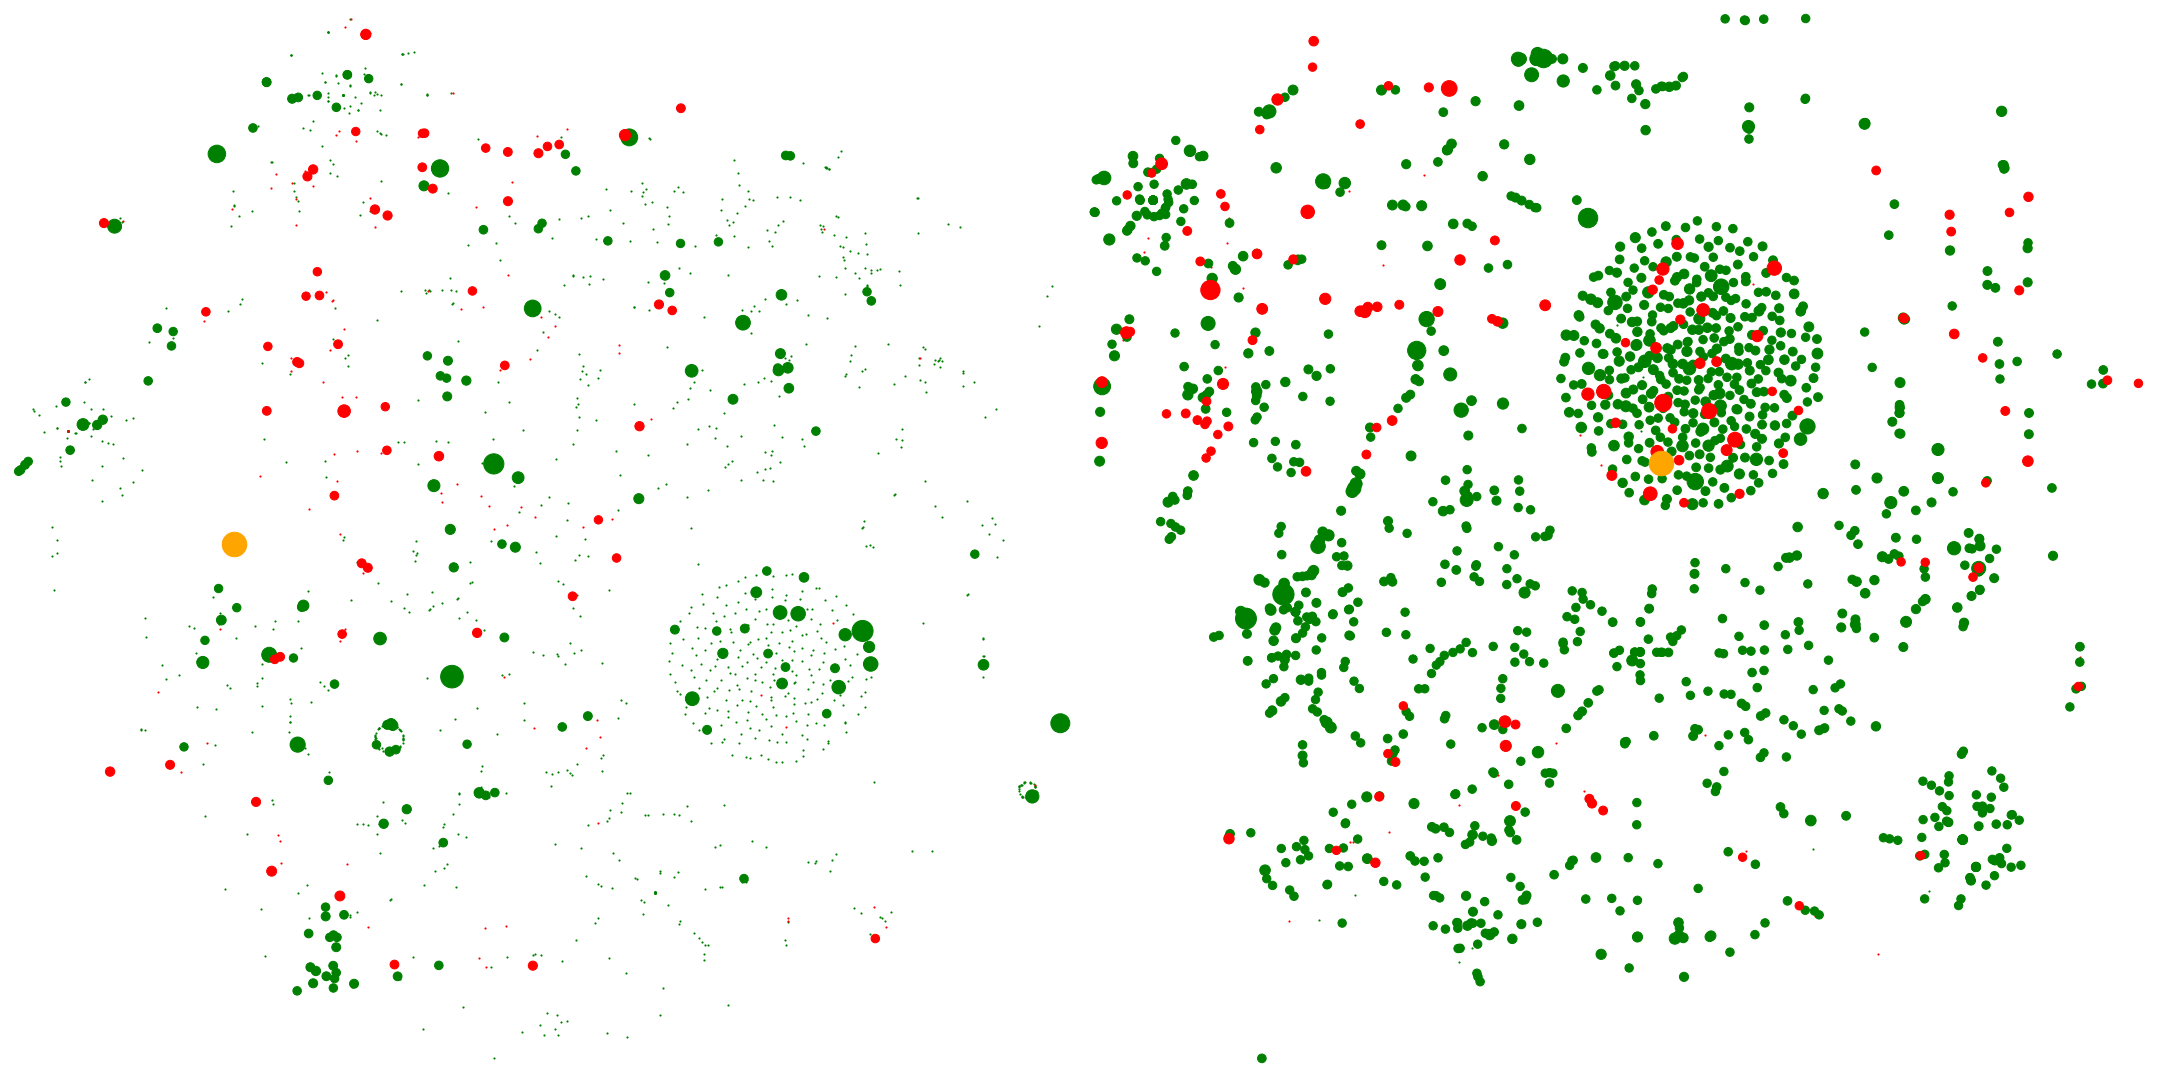

In [18]:
fig = plt.figure(figsize=(30, 15))

for i, year in enumerate([1995, 2011]):
    plt.subplot(1, 2, i + 1)
    whichvector = 'Export'
    whichyearnetwork = year
    pct_change_range = 1.0
    economyname = 'China'
    industryname = 'Electrical and Optical Equipment'

    pi_perturbedpath = "./markov/Data/perturb/pi_perturbed_How_much_change_-99_year_" + str(
        whichyearnetwork) + ".csv"
    pi_perturbed = pd.read_csv(pi_perturbedpath, index_col=0)

    pi_normalpath = "./markov/Data/perturb/pi_normal_How_much_change_-99_year_" + str(
        whichyearnetwork) + ".csv"
    pi_normal = pd.read_csv(pi_normalpath, index_col=0)

    pi_diff_path = "./markov/Data/perturb/PerturbationOnIndustries_Change_PCT_How_much_change_-99_year_" + str(
        whichyearnetwork) + ".csv"
    pi_diff = pd.read_csv(pi_diff_path, index_col=0)

    pi_diff = pi_diff.loc[str(economyname + '-' + industryname)].values[:1435]
    perturbed = pi_perturbed.loc[str(
        economyname + '-' + industryname)].values[:1435]
    normal = pi_normal.values[0, :1435]

    path = "./markov/Data/perturb/Economy_map_" + whichvector + "_" + str(
        whichyearnetwork) + ".json"
    #now assume we have it
    import json
    with open(path) as data_file:
        data = json.load(data_file)
    NETWORK_RESULTS = data
    NETWORK_RESULTS = data
    NETWORK_RESULTS['pi_perturbed'] = list(perturbed * 1e4)
    NETWORK_RESULTS['pi_normal'] = list(normal * 1e4)
    NETWORK_RESULTS['pi_diff'] = list(pi_diff)

    ind_industry = set(
        np.where(np.asarray(NETWORK_RESULTS['industry']) == industryname)[0])
    ind_economy = set(
        np.where(np.asarray(NETWORK_RESULTS['economy']) == economyname)[0])
    indmainnode = list(ind_industry.intersection(ind_economy))[0]

    indsmall = np.where(
        np.abs(np.asarray(NETWORK_RESULTS['pi_diff'])) < pct_change_range)[0]
    indsmed = np.where(
        np.abs(np.asarray(NETWORK_RESULTS['pi_diff'])) >= pct_change_range)[0]

    x = np.asarray(NETWORK_RESULTS['XCoord'])[indsmall]
    y = 1000 - np.asarray(NETWORK_RESULTS['YCoord'])[indsmall]
    vals = np.asarray(NETWORK_RESULTS['pi_diff'])[indsmall]

    plt.scatter(x[vals >= 0], y[vals >= 0], s=1.3, color='g')
    plt.scatter(x[vals < 0], y[vals < 0], s=1.3, color='r')

    x = np.asarray(NETWORK_RESULTS['XCoord'])[indsmed]
    y = 1000 - np.asarray(NETWORK_RESULTS['YCoord'])[indsmed]
    vals = np.asarray(NETWORK_RESULTS['pi_diff'])[indsmed]
    size = 70 + 3 * np.asarray(NETWORK_RESULTS['pi_normal']) / 1 * (
        1 + np.asarray(NETWORK_RESULTS['pi_diff']) / 100)
    size = size[indsmed]

    plt.scatter(x[vals >= 0], y[vals >= 0], s=size[vals >= 0], color='g')
    plt.scatter(x[vals < 0], y[vals < 0], s=size[vals < 0], color='r')

    plt.scatter(
        np.asarray(NETWORK_RESULTS['XCoord'])[indmainnode],
        1000 - np.asarray(NETWORK_RESULTS['YCoord'])[indmainnode],
        s=[600],
        color='orange')

    plt.xlim(-11, 1011)
    plt.ylim(-11, 1011)
    plt.axis('off')
    plt.tight_layout()

path = './markov/Images/perturb_china.tiff'
#fig.savefig(path,dpi=400)
plt.show();
plt.close();

## Systemic fragility vs. systemic influence of each industry for the year 2011

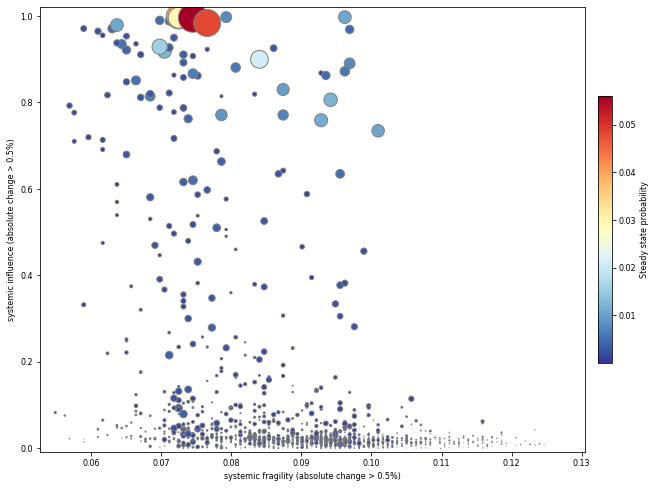

In [19]:
whichyearnetwork = 2011
How_much_change = -99

pi_perturbedpath = "./markov/Data/perturb/pi_perturbed_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_perturbed = pd.read_csv(pi_perturbedpath, index_col=0)

pi_normalpath = "./markov/Data/perturb/pi_normal_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_normal = pd.read_csv(pi_normalpath, index_col=0)

pi_diff_path = "./markov/Data/perturb/PerturbationOnIndustries_Change_PCT_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_diff = pd.read_csv(pi_diff_path, index_col=0)

# Threshold of change in pct
thresh = .5

dim = pi_diff.shape[1]

# Systemic Influence
no_of_pos_affecting = (pi_diff.values[:dim, :dim] > thresh).sum(axis=1)
no_of_neg_affecting = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=1)

ind_pos_affecting = pi_diff.values[:dim, :dim] > thresh
ind_neg_affecting = pi_diff.values[:dim, :dim] < -1 * thresh
pos_affecting = np.zeros(dim)
neg_affecting = np.zeros(dim)
for i in range(dim):
    pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
        pi_normal.values[0, :dim][ind_pos_affecting[i]])
    neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
        pi_normal.values[0, :dim][ind_neg_affecting[i]])

# We want to take out the effect each node on itself
self_change = np.diag(pi_diff.values[:, :dim]) * pi_normal.values[0, :dim]

sum_of_affecting = np.abs(neg_affecting) + pos_affecting - np.abs(self_change)
pi_norm = pi_normal.values[0, :dim]

systemic_influence = (no_of_pos_affecting + no_of_neg_affecting) / float(dim)

# Systemic Fragility
no_of_pos_affected = (pi_diff.values[:dim, :dim] > thresh).sum(axis=0)
no_of_neg_affected = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=0)

ind_pos_affected = pi_diff.values[:dim, :dim] > thresh
ind_neg_affected = pi_diff.values[:dim, :dim] < -1 * thresh
pos_affected = np.zeros(dim)
neg_affected = np.zeros(dim)

for i in range(dim):
    pos_affected[i] = pi_diff.values[ind_pos_affected[:dim, i],
                                     i].sum() * pi_normal.values[0, i]
    neg_affected[i] = pi_diff.values[ind_neg_affected[:dim, i],
                                     i].sum() * pi_normal.values[0, i]

systemic_fragility = (no_of_pos_affected + no_of_neg_affected) / float(dim)

sum_of_affected = np.abs(neg_affected) + pos_affected - np.abs(self_change)

fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)

ax = plt.gca()

x = systemic_fragility
y = systemic_influence

p = ax.scatter(
    x,
    y,
    c=pi_norm,
    s=pi_norm[:dim] * 15000,
    marker='o',
    edgecolor='gray',
    cmap=plt.cm.RdYlBu_r,
    alpha=1)

plt.plot(x, y, 'ob', markersize=.3, alpha=.05)

plt.xlabel('systemic fragility (absolute change > {}%)'.format(thresh))
plt.ylabel('systemic influence (absolute change > {}%)'.format(thresh))

cb = plt.colorbar(p, shrink=.6, pad=.02)
cb.set_label('Steady state probability')

eps = .022
xmin = x.min() - eps * .1
xmax = x.max() + eps * .05

ymin = y.min() - eps * .4
ymax = y.max() + eps

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

path = './markov/Images/Fragility_Influence.tiff'
# fig.savefig(path, dpi=300)

plt.show();
cb.remove()
plt.close();

## Paradoxical effects of slowing down the activity of economic nodes on Kemeny constant

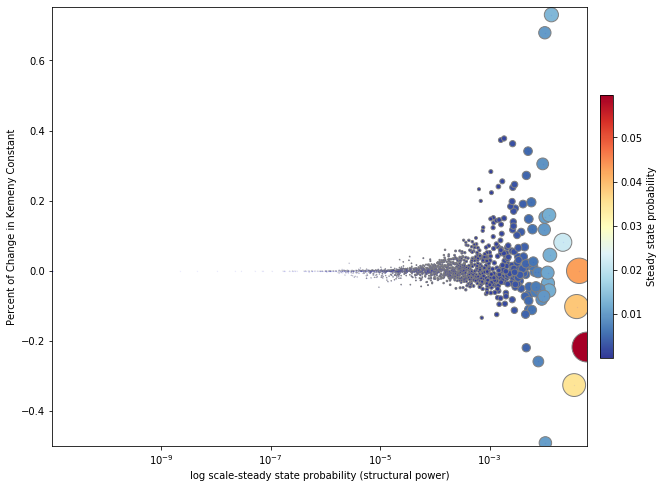

In [20]:
%matplotlib inline
#KEMENY CHNAGE
whichyearnetwork = 2010
How_much_change = -99

Kemeny_Change_PCTpath = "./markov/Data/perturb/Kemeny_Change_PCT_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
Kemeny_Change_PCT = pd.read_csv(Kemeny_Change_PCTpath, index_col=0)

pi_normalpath = "./markov/Data/perturb/pi_normal_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_normal = pd.read_csv(pi_normalpath, index_col=0)

#Threshold of change in pct
thresh = .5

dim = pi_normal.shape[1]
pi_norm = pi_normal.values[0, :dim]

fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)

ax = plt.gca()
ax.set_xscale('log')

x = pi_norm
y = Kemeny_Change_PCT.values[:dim]

p = ax.scatter(
    x,
    y,
    c=pi_norm,
    s=pi_norm[:dim] * 15000,
    marker='o',
    edgecolor='gray',
    cmap=plt.cm.RdYlBu_r,
    alpha=1)


plt.plot(x, y, 'ob', markersize=.3, alpha=.099)

plt.xlabel('log scale-steady state probability (structural power)')
plt.ylabel('Percent of Change in Kemeny Constant')

cb = plt.colorbar(p, shrink=.6, pad=.02)
cb.set_label('Steady state probability')

eps = .022
xmin = x.min()
xmax = x.max() + eps * .05

ymin = y.min() - eps * .4
ymax = y.max() + eps

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

path = './markov/Images/Kemeny_Eigen.tiff'
#fig.savefig(path, dpi=300)

plt.show();
plt.close();

## Calculating Systemic Influence, Systemic Fragility other measures from 1995 to 2011

In [21]:
How_much_change = -99
whichyearnetwork = 1995
Kemeny_Change_PCTpath = "./markov/Data/perturb/Kemeny_Change_PCT_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
Kemeny_Change_PCT = pd.read_csv(Kemeny_Change_PCTpath, index_col=0)

######################################
sys_fragility_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
sys_influence_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
Kemeny_Change_PCT_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
Pi_normall_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
outdegree_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
indegree_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
######################################

for year in range(1995, 2012):
    whichyearnetwork = year
    How_much_change = -99
    Kemeny_Change_PCTpath = "./markov/Data/perturb/Kemeny_Change_PCT_How_much_change_" + str(
        How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
    Kemeny_Change_PCT = pd.read_csv(Kemeny_Change_PCTpath, index_col=0)

    pi_perturbedpath = "./markov/Data/perturb/pi_perturbed_How_much_change_" + str(
        How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
    pi_perturbed = pd.read_csv(pi_perturbedpath, index_col=0)

    pi_normalpath = "./markov/Data/perturb/pi_normal_How_much_change_" + str(
        How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
    pi_normal = pd.read_csv(pi_normalpath, index_col=0)

    pi_diff_path = "./markov/Data/perturb/PerturbationOnIndustries_Change_PCT_How_much_change_" + str(
        How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
    pi_diff = pd.read_csv(pi_diff_path, index_col=0)

    # Systemic Influence Vs. Systemice Fragility
    # Threshold of change in pct
    thresh = .5
    dim = pi_diff.shape[1]

    # Systemic Influence
    no_of_pos_affecting = (pi_diff.values[:dim, :dim] > thresh).sum(axis=1)
    no_of_neg_affecting = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=1)
    s = float(dim)

    ind_pos_affecting = pi_diff.values[:dim, :dim] > thresh
    ind_neg_affecting = pi_diff.values[:dim, :dim] < -1 * thresh
    pos_affecting = np.zeros(dim)
    neg_affecting = np.zeros(dim)
    for i in range(dim):
        pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
            pi_normal.values[0, :dim][ind_pos_affecting[i]])
        neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
            pi_normal.values[0, :dim][ind_neg_affecting[i]])

    # We want to take out the effect each node on itself
    self_change = np.diag(pi_diff.values[:, :dim]) * pi_normal.values[0, :dim]
    sum_of_affecting = np.abs(neg_affecting) + pos_affecting - np.abs(
        self_change)
    pi_norm = pi_normal.values[0, :dim]

    systemic_influence = (no_of_pos_affecting + no_of_neg_affecting) / s

    #Systemic Fragility
    no_of_pos_affected = (pi_diff.values[:dim, :dim] > thresh).sum(axis=0)
    no_of_neg_affected = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=0)

    ind_pos_affected = pi_diff.values[:dim, :dim] > thresh
    ind_neg_affected = pi_diff.values[:dim, :dim] < -1 * thresh
    pos_affected = np.zeros(dim)
    neg_affected = np.zeros(dim)
    for i in range(dim):
        pos_affected[i] = pi_diff.values[ind_pos_affected[:dim, i],
                                         i].sum() * pi_normal.values[0, i]
        neg_affected[i] = pi_diff.values[ind_neg_affected[:dim, i],
                                         i].sum() * pi_normal.values[0, i]

    systemic_fragility = (no_of_pos_affected + no_of_neg_affected) / s

    sys_fragility_all[year] = systemic_fragility
    sys_influence_all[year] = systemic_influence
    Kemeny_Change_PCT_all[year] = Kemeny_Change_PCT.values[:]
    Pi_normall_all[year] = pi_normal.T.values[:]
    outdegree_all[year] = np.sum(TMs[year - 1995] > 0, axis=1)
    indegree_all[year] = np.sum(TMs[year - 1995] > 0, axis=0)

In [22]:
# Here we calculate the indiced of the nodes of Rest of the World (ROW) and the Governments.
# We remove them in some analyses.
i = 40
ind_ROW = list(range(i * industry_n,
                     (i + 1) * industry_n)) + [industry_n * economy_n + i]
ind_GOvs = range(industry_n * economy_n, industry_n * economy_n + economy_n)
ind_all = range(1476)
ind_all_except_ROW = list(set(ind_all).difference(ind_ROW))
ind_all_except_ROW_GOVS = list(set(ind_all_except_ROW).difference(ind_GOvs))

## The paradoxical effect of slowdown in the activity economic nodes

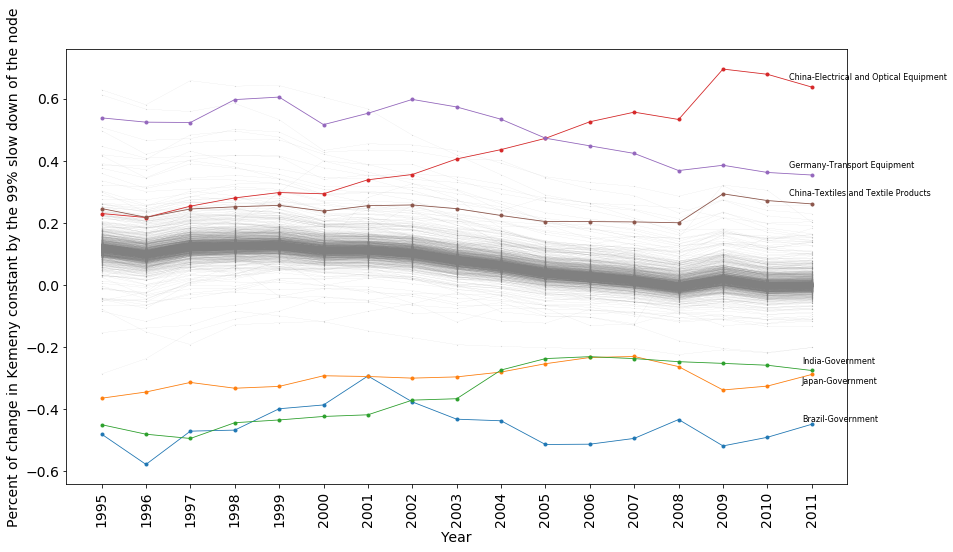

In [23]:
net_index = Kemeny_Change_PCT_all.loc[Kemeny_Change_PCT_all.index[
    ind_all_except_ROW]].copy()
DF = net_index.sort_values(1995, ascending=False)
positive1995 = DF.index[:10].values[:]

DF = net_index.sort_values(1995, ascending=True)
negative1995 = DF.index[:10].values[:]

DF = net_index.sort_values(2011, ascending=False)
positive2011 = DF.index[:10].values[:]

DF = net_index.sort_values(2011, ascending=True)
negative2011 = DF.index[:10].values[:]

fig = plt.figure(figsize=(14, 8))

plt.plot(
    net_index.values[:].T, '.-', color='gray', linewidth=.05, markersize=.2)

plt.plot(
    net_index.loc[negative2011[:3]].values[:].T, '.-', linewidth=.81)

plt.plot(
    net_index.loc[positive2011[:3]].values[:].T, '.-', linewidth=.81)

i = 0
y = net_index.loc[negative2011[i]][2011]
plt.annotate(
    negative2011[i],
    size=8,
    xy=(16, y + .002),
    xytext=(-10, 0),
    textcoords='offset points',
    ha='left',
    va='bottom')

i = 1
y = net_index.loc[negative2011[i]][2011]
plt.annotate(
    negative2011[i],
    size=8,
    xy=(16, y + .002),
    xytext=(-10, -12),
    textcoords='offset points',
    ha='left',
    va='bottom')

i = 2
y = net_index.loc[negative2011[i]][2011]
plt.annotate(
    negative2011[i],
    size=8,
    xy=(16, y + .002),
    xytext=(-10, 4),
    textcoords='offset points',
    ha='left',
    va='bottom')

for i in range(3):
    y = net_index.loc[positive2011[i]][2011]
    plt.annotate(
        positive2011[i],
        size=8,
        xy=(16, y + .002),
        xytext=(-23, 5),
        textcoords='offset points',
        ha='left',
        va='bottom')

plt.ylabel(
    'Percent of change in Kemeny constant by the 99% slow down of the node')
plt.xlabel('Year')
plt.xticks(
    range(17), range(1995, 2012), rotation='vertical')
font = {'size': 14.}
plt.rc('font', **font)
path = './markov/Images/Percent_of_change_Kemeny.tiff'
# fig.savefig(path,dpi=300)

## Top 10 nodes with the highest systemic influence in 2011

In [24]:
year = 2011

dd = np.concatenate(
    (Pi_normall_all.index.values[:][:, np.newaxis],
     Pi_normall_all[year].values[:][:, np.newaxis],
     sys_fragility_all[year].values[:][:, np.newaxis],
     sys_influence_all[year].values[:][:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF = DF.loc[DF.index[ind_all_except_ROW]]

DF.head()
DF = DF.sort_values('Systemic Influence', ascending=False)
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Fragility,Systemic Influence
1,China-Government,0.0407637,0.0724932,0.998645
2,Japan-Real Estate Activities,0.00434353,0.0718157,0.997967
3,Brazil-Government,0.0106923,0.096206,0.99729
4,India-Government,0.00788957,0.0792683,0.99729
5,USA-Real Estate Activities,0.00796444,0.0738482,0.995935
6,Japan-Government,0.0294709,0.0724932,0.995935
7,USA-Government,0.0560428,0.0745257,0.995935
8,"USA-Retail Trade, Except of Motor Vehicles and...",0.0049287,0.0731707,0.995257
9,"USA-Wholesale Trade and Commission Trade, Exce...",0.00488901,0.0738482,0.99187
10,USA-Renting of M&Eq and Other Business Activities,0.0116091,0.0718157,0.99187


## Top 10 nodes with the lowest systemic fragility in 2011

In [25]:
year = 2011

dd = np.concatenate(
    (Pi_normall_all.index.values[:][:, np.newaxis],
     Pi_normall_all[year].values[:][:, np.newaxis],
     sys_fragility_all[year].values[:][:, np.newaxis],
     sys_influence_all[year].values[:][:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF = DF.loc[DF.index[ind_all_except_ROW]]

DF.head()
DF = DF.sort_values('Systemic Fragility', ascending=True)
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Fragility,Systemic Influence
1,UK-Electrical and Optical Equipment,0.000292468,0.054878,0.0826558
2,Finland-Electrical and Optical Equipment,0.000137664,0.0562331,0.0758808
3,"Taiwan-Manufacturing, Nec; Recycling",3.36116e-05,0.0569106,0.0223577
4,Germany-Electrical and Optical Equipment,0.00154004,0.0575881,0.776423
5,Germany-Chemicals and Chemical Products,0.00110951,0.0575881,0.710027
6,"Ireland-Machinery, Nec",1.32138e-05,0.0589431,0.0149051
7,Malta-Electrical and Optical Equipment,6.45902e-06,0.0589431,0.0216802
8,USA-Electrical and Optical Equipment,0.00232597,0.0589431,0.970867
9,"Germany-Machinery, Nec",0.00183113,0.0596206,0.719512
10,Denmark-Chemicals and Chemical Products,7.47541e-05,0.0609756,0.0264228


## Top 10 nodes with the highest positive effects on Kemeny constant in 2011

In [26]:
year = 2011

dd = np.concatenate(
    (Pi_normall_all.index.values[:][:, np.newaxis],
     Pi_normall_all[year].values[:][:, np.newaxis],
     sys_influence_all[year].values[:][:, np.newaxis],
     Kemeny_Change_PCT_all[year].values[:][:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Influence', 'Pct of chng Kemeny'
    ])

DF = DF.loc[DF.index[ind_all_except_ROW]]

DF.head()
DF = DF.sort_values('Pct of chng Kemeny', ascending=False)
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Influence,Pct of chng Kemeny
1,China-Electrical and Optical Equipment,0.0109195,0.978997,0.637486
2,Germany-Transport Equipment,0.00282169,0.811653,0.354232
3,China-Textiles and Textile Products,0.00498553,0.970867,0.2612
4,"Germany-Machinery, Nec",0.00183113,0.719512,0.255455
5,Germany-Electrical and Optical Equipment,0.00154004,0.776423,0.230203
6,Germany-Chemicals and Chemical Products,0.00110951,0.710027,0.209375
7,Romania-Government,0.000723924,0.0765583,0.203782
8,Russia-Government,0.0104454,0.734417,0.202094
9,USA-Transport Equipment,0.00252037,0.910569,0.191263
10,"USA-Coke, Refined Petroleum and Nuclear Fuel",0.00264798,0.469512,0.182051


## Top 10 nodes with the highest negative effects on Kemeny constant in 2011

In [27]:
year = 2011

dd = np.concatenate(
    (Pi_normall_all.index.values[:][:, np.newaxis],
     Pi_normall_all[year].values[:][:, np.newaxis],
     sys_influence_all[year].values[:][:, np.newaxis],
     Kemeny_Change_PCT_all[year].values[:][:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Influence', 'Pct of chng Kemeny'
    ])

DF = DF.loc[DF.index[ind_all_except_ROW]]

DF.head()
DF = DF.sort_values('Pct of chng Kemeny', ascending=True)
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Influence,Pct of chng Kemeny
1,Brazil-Government,0.0106923,0.99729,-0.448618
2,Japan-Government,0.0294709,0.995935,-0.28818
3,India-Government,0.00788957,0.99729,-0.275446
4,Mexico-Government,0.00473883,0.968835,-0.201355
5,USA-Government,0.0560428,0.995935,-0.201247
6,Greece-Government,0.000652282,0.0623306,-0.133354
7,Finland-Government,0.00127287,0.105014,-0.116016
8,Spain-Government,0.00610205,0.871951,-0.114455
9,China-Government,0.0407637,0.998645,-0.111065
10,Sweden-Government,0.0030026,0.377371,-0.110952


## Top 10 industry nodes with the highest negative effects on Kemeny constant in 2011

In [28]:
year = 2011

dd = np.concatenate(
    (Pi_normall_all.index.values[:][:, np.newaxis],
     Pi_normall_all[year].values[:][:, np.newaxis],
     sys_influence_all[year].values[:][:, np.newaxis],
     Kemeny_Change_PCT_all[year].values[:][:, np.newaxis]),
    axis=1)
DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Influence', 'Pct of chng Kemeny'
    ])

DF = DF.loc[DF.index[ind_all_except_ROW_GOVS]]

DF.head()
DF = DF.sort_values('Pct of chng Kemeny', ascending=True)
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Influence,Pct of chng Kemeny
1,Japan-Real Estate Activities,0.00434353,0.997967,-0.0994393
2,Brazil-Public Admin and Defence; Compulsory So...,0.00153962,0.0264228,-0.0872356
3,"India-Agriculture, Hunting, Forestry and Fishing",0.00157759,0.0528455,-0.0769576
4,USA-Real Estate Activities,0.00796444,0.995935,-0.0739146
5,Australia-Real Estate Activities,0.00132178,0.0121951,-0.0690959
6,France-Real Estate Activities,0.00190527,0.00880759,-0.0678286
7,Japan-Public Admin and Defence; Compulsory Soc...,0.00371188,0.910569,-0.0646992
8,Brazil-Real Estate Activities,0.000888012,0.0216802,-0.0593976
9,Japan-Renting of M&Eq and Other Business Activ...,0.00458614,0.988482,-0.0576155
10,"India-Retail Trade, Except of Motor Vehicles a...",0.000777359,0.0230352,-0.0572433


## Clustering the nodes

In [81]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from sompy.sompy import SOMFactory
from sompy import mapview

In [82]:
msz10 = 50
msz11 = 50

Data = np.concatenate(
    (Pi_normall_all.values[:], Kemeny_Change_PCT_all[:],
     sys_fragility_all.values[:], sys_influence_all.values[:],
     indegree_all.values[:], outdegree_all.values[:]),
    axis=1)

In [83]:
names = []
for what in [
        'structural power', 'pct-change-Kemeny', 'fragility', 'influence',
        'indegree', 'outdegree'
]:
    for year in range(1995, 2012):
        names.append(what + '-' + str(year))

In [84]:
sm = SOMFactory().build(
    Data, mapsize=[msz10, msz11], initialization='pca', component_names=names)
sm.train(n_job=1, verbose=False, train_rough_len=2, train_finetune_len=5)

In [85]:
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print("Topographic error = %s; Quantization error = %s" % (topographic_error,
                                                           quantization_error))

Topographic error = 0.0027100271002710027; Quantization error = 1.455188100598882


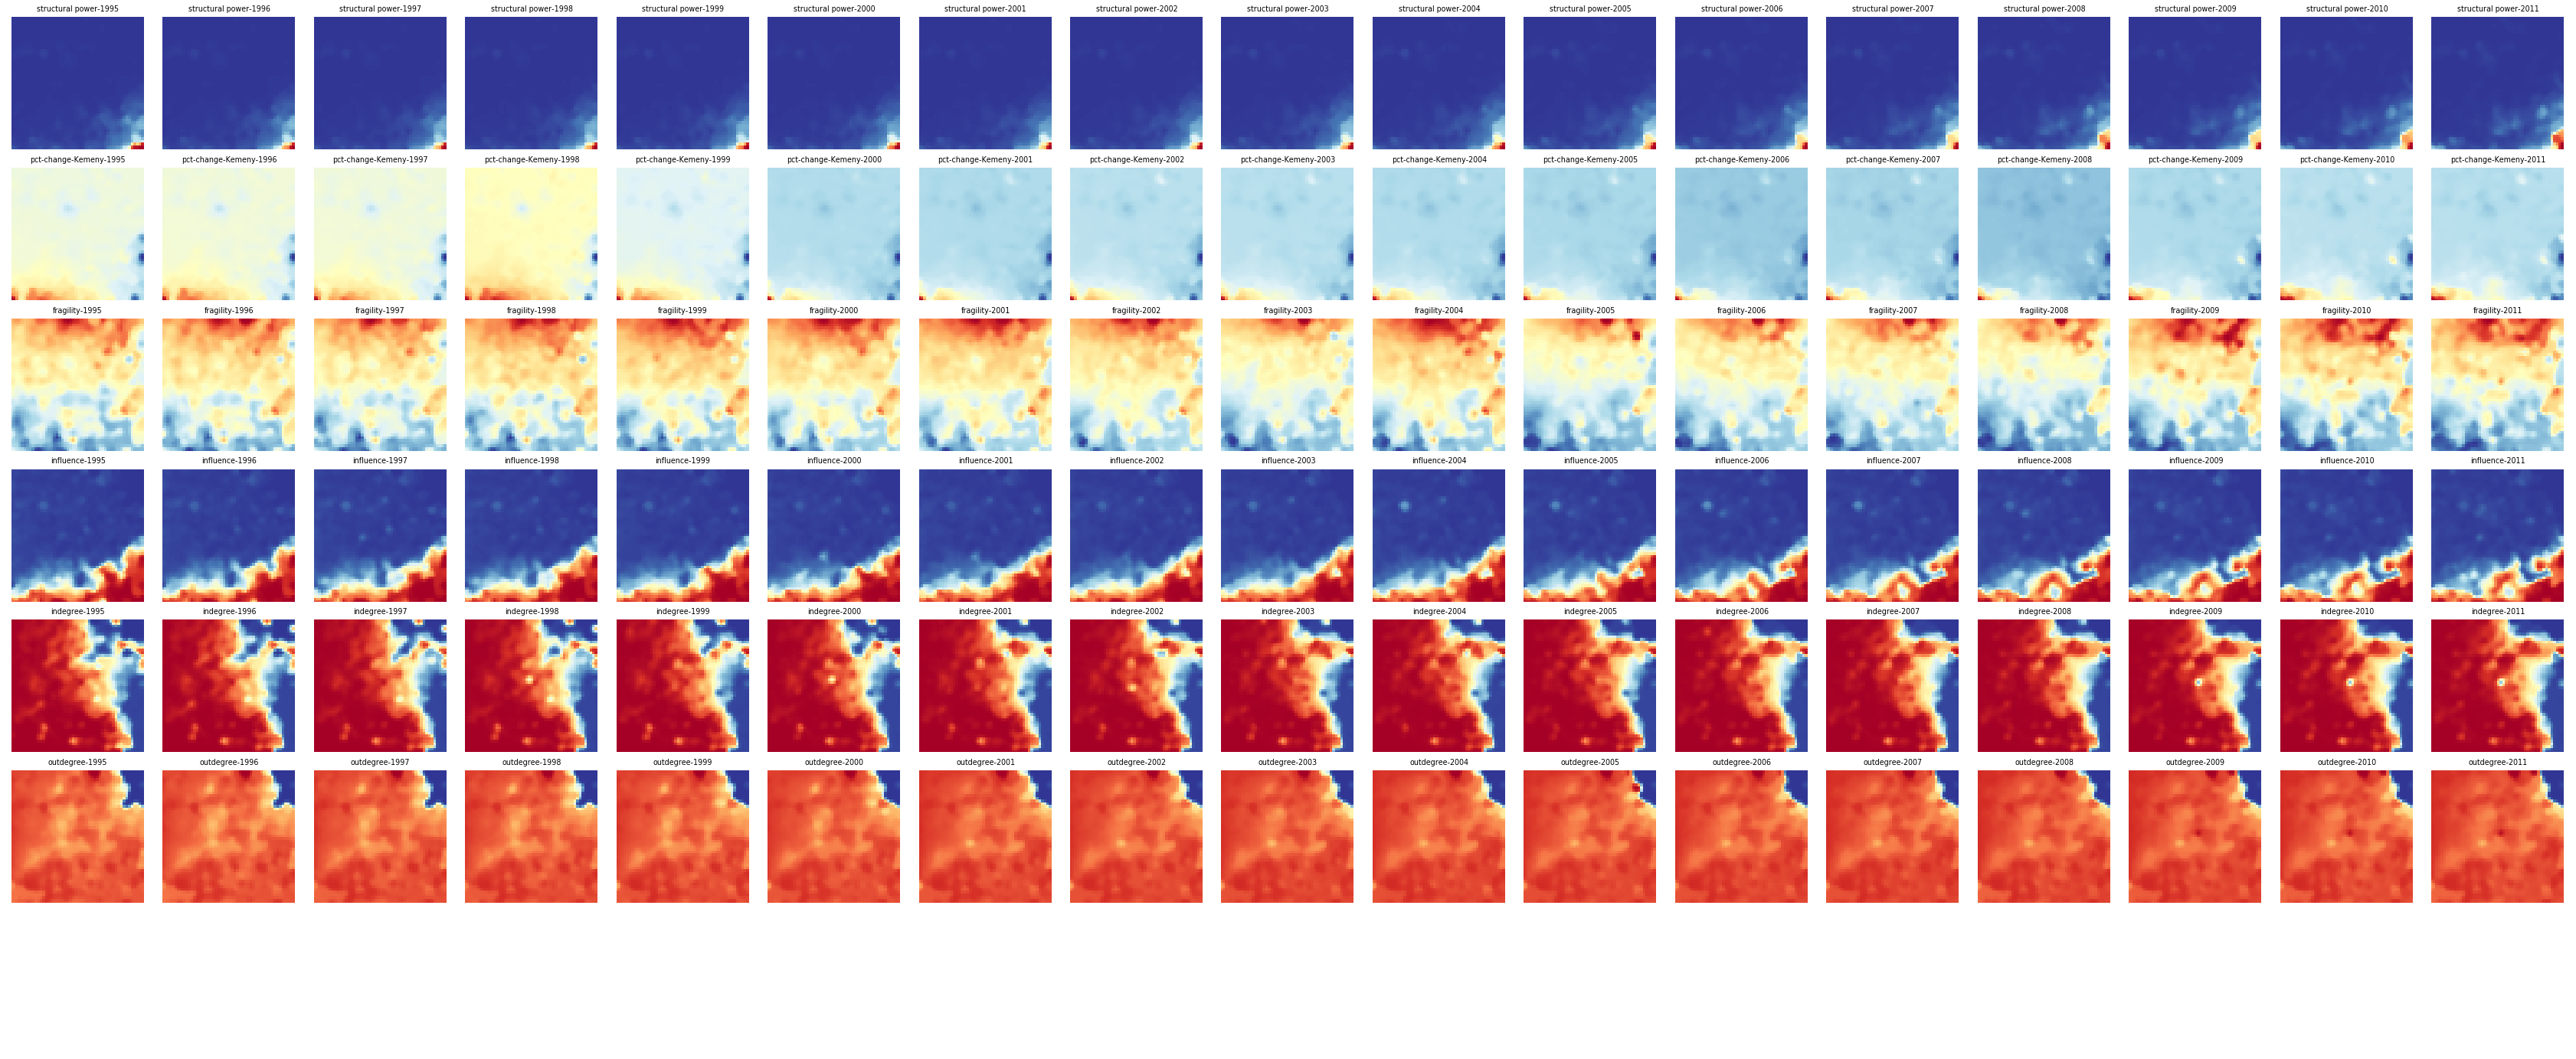

In [86]:
from sompy.visualization.mapview import View2D
from sompy.visualization.mapview import View2DPacked
view2D = View2DPacked(20, 20, '', text_size=8)
view2D.show(sm, col_sz=17, which_dim="all")